<div style="vertical-align:middle">
<img width="170" style="float: right;" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />
<h1>Aprendizaje por refuerzo 1: 1D-ungeon<a id="top"></a></h1>
<i><small>Fuentes: <a href="https://github.com/etsisi/Robotica">github.com/etsisi/Robotica</a><br>Última actualización: 2023-10-21</i>
</div>
<hr>

## Introducción

En este notebook aprenderemos las bases de cómo implementar una política de decisión (_policy_) y qué es el algoritmo Q-Learning. Para ello usaremos un ejemplo básico de RPG; tan básico que sólo habrá que explorar... una mazmorra en una dimensión.

## Objetivos

Los objetivos de este Notebook son los siguientes:

- Sentar las bases de qué son las _policy_ y por qué son importantes en el balance de exploración/explotación.
- Aprender cómo funciona el algoritmo de Q-Learning para la asignación de valor a posibles transiciones entre estados.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del _notebook_.

In [2]:
import enum
import random

***

## Descripción del problema

Somos un aventurero en una mazmorra muy simple, 8 celdas una detrás de otra como se ve en la imagen adjunta:

![](images/1dungeon-1.png)

Nuestro conocimiento de la mazmorra es el siguiente:

1. Sabemos que la mazmorra tiene 8 habitaciones.
2. Nuestras acciones son movernos a la derecha (una habitación cada vez) o a la izquierda (todas las habitaciones hasta el principio). Es lo que tiene visitar una mazmorra encantada.
3. Un conjuro de confusión existente en las habitaciones nos afecta un 10% de las veces, haciendo que cambie nuestra orientación (es decir, a veces decidimos ir a la derecha y vamos a la izquierda y viceversa).
3. Algunas habitaciones tienen tesoro.

Lo que no sabemos de la mazmorra es que:

1. La primera habitación tiene una recompensa de 1 moneda de oro.
2. La última habitación tiene 10 monedas de oro.
3. Las monedas se regeneran cada turno.

Podemos representar el Proceso de Decisión de Markov (en realidad una pequeña porción, porque es relativamente grande) con el siguiente grafo:

![](images/1dungeon-2.png)

Sí, es un poco desparrame. Es una de las desventajas de este tipo de modelos, que está muy bien para casos muy sencillos, pero representar espacios no tan sencillos ya es un reto.

In [3]:
TRAIN_STEPS = 10**6

In [4]:
class Actions(enum.Enum):
    LEFT = 0
    RIGHT = 1
    
    def switch(self):
        if self == Actions.LEFT:
            return Actions.RIGHT
        else:
            return Actions.LEFT

In [5]:
class Dungeon:
    def __init__(self, *, rooms, p_confussion):
        self.rooms = rooms
        self.p_confussion = p_confussion
        self.state = 0

    def step(self, action):
        if random.random() < self.p_confussion:
            action = action.switch()

        match action:
            case Actions.LEFT:
                self.state = 0
            case Actions.RIGHT:
                if self.state < len(self.rooms) - 1:
                    self.state += 1

        return self.state, self.rooms[self.state]

    def reset(self):
        self.state = 0

## Primera aproximación: El aventurero que no sabe si va o viene

La primera aproximación será, simplemente, escoger ir a izquierda o a derecha aleatoriamente.

In [6]:
class Hero:
    def __init__(self, *, dungeon):
        self.dungeon = dungeon

    def select_action(self, state):
        return Actions.LEFT if random.random() < 0.5 else Actions.RIGHT

In [7]:
dungeon = Dungeon(rooms=[1, 0, 0, 0, 0, 0, 0, 10], p_confussion=0.1)
hero = Hero(dungeon=dungeon)

total = 0
for i in range(TRAIN_STEPS):
    old_state = dungeon.state
    action = hero.select_action(old_state) 
    new_state, reward = dungeon.step(action)
    total += reward

print(f'Total reward: {total}')

Total reward: 578578


## Segunda aproximación: El aventurero enzarpado

Nuestro segundo aventurero seguirá la siguiente estrategia de toma de decisiones:

1. Si desde donde estoy hay una acción más lucrativa que otra, realizaré dicha acción.
2. Si ambas son iguales, escogeré una aleatoria.

Para ello, en su parte trasera del mapa irá apuntando qué acciones han sido más lucrativas que otras. Veamos una simulación de este comportamiento.

In [8]:
class Hero:
    def __init__(self, *, dungeon):
        self.dungeon = dungeon
        self.actions_values = {
            Actions.LEFT: [0 for _ in dungeon.rooms],
            Actions.RIGHT: [0 for _ in dungeon.rooms],
        }

    def select_action(self, state):
        if self.actions_values[Actions.RIGHT][state] < self.actions_values[Actions.LEFT][state]:
            return Actions.LEFT
        elif self.actions_values[Actions.LEFT][state] < self.actions_values[Actions.RIGHT][state]:
            return Actions.RIGHT
        else:
            return Actions.LEFT if random.random() < 0.5 else Actions.RIGHT

    def update(self, old_state, action, reward):
        self.actions_values[action][old_state] += reward

    def __str__(self):
        string = ''
        for k, v in self.actions_values.items():
            string += f'{k}: {v}\n'
        return string

In [9]:
dungeon = Dungeon(rooms=[1, 0, 0, 0, 0, 0, 0, 10], p_confussion=0.1)
hero = Hero(dungeon=dungeon)

total = 0
for i in range(TRAIN_STEPS):
    old_state = dungeon.state
    action = hero.select_action(old_state) 
    new_state, reward = dungeon.step(action)
    hero.update(old_state, action, reward)
    total += reward

print(hero)
print(f'Total reward: {total}')

Actions.LEFT: [808682, 81659, 8059, 836, 82, 0, 9, 0]
Actions.RIGHT: [0, 0, 0, 0, 0, 1, 0, 0]

Total reward: 899328


## Tercera aproximación: Aventurero que sigue la estrategia $\epsilon$-greedy

En la anterior aproximación, el aventurero enzarpado **siempre** iba hacia la mejor recompensa que había encontrado en el pasado. Claro, lo más probable es ir cayendo en la recompensa pequeña por lo que prácticamente nunca irá hacia la derecha. Estamos prácticamente explotando y no explorando.

La estrategia $\epsilon$-greedy tratará de solventar esto. Es un método muy simple para equilibrar la exploración y la explotación aleatoriamente. El factor $\epsilon \in [0, 1]$ es el que se encargará de determinar cuál es la acción preferida, si explotar o explorar, y tiene la siguiente forma:

$$p_\epsilon = 1 - \epsilon$$

Cuando $\epsilon$ está muy próximo a $1$, el comportamiento será de total exploración, es decir, un comportamiento aleatorio, y cuando está muy próximo a $0$, la acción que seguirá el agente es de total explotación.

Nuestra implementación dará un paso más y usará la estrategia $\epsilon$-greedy con decaimiento. Eso significa que el factor épsilon no es fijo, sino que a lo largo del entrenamiento irá disminuyendo, de tal manera que en los primeros estadios del proceso de entrenamiento tendrá un valor muy alto, favoreciendo la exploración, y según avance el entrenamiento irá decayendo favoreciendo la explotación. Esto es porque se espera que una vez avanzado el entrenamiento, el algoritmo ha sido capaz de encontrar regiones prometedoras con la exploración y ahora queremos explotarlas a ver hasta qué punto son buenas.

In [10]:
class Hero:
    def __init__(self, *, dungeon, epsilon, d_epsilon):
        self.dungeon = dungeon
        self.epsilon = epsilon
        self.d_epsilon = d_epsilon
        self.actions_values = {
            Actions.LEFT: [0 for _ in dungeon.rooms],
            Actions.RIGHT: [0 for _ in dungeon.rooms],
        }

    def select_action(self, state):
        if random.random() < 1 - self.epsilon:
            if self.actions_values[Actions.RIGHT][state] < self.actions_values[Actions.LEFT][state]:
                return Actions.LEFT
            elif self.actions_values[Actions.LEFT][state] < self.actions_values[Actions.RIGHT][state]:
                return Actions.RIGHT
        return Actions.LEFT if random.random() < 0.5 else Actions.RIGHT

    def update(self, old_state, action, reward):
        self.actions_values[action][old_state] += reward

        if self.epsilon > 0:
            self.epsilon -= self.d_epsilon

    def __str__(self):
        string = ''
        for k, v in self.actions_values.items():
            string += f'{k}: {v}\n'
        return string

In [11]:
dungeon = Dungeon(rooms=[1, 0, 0, 0, 0, 0, 0, 10], p_confussion=0.1)
hero = Hero(dungeon=dungeon, epsilon=1.0, d_epsilon=1 / (TRAIN_STEPS / 2))

total = 0
for i in range(TRAIN_STEPS):
    old_state = dungeon.state
    action = hero.select_action(old_state)
    new_state, reward = dungeon.step(action)
    hero.update(old_state, action, reward)
    total += reward

print(hero)
print(f'Total reward: {total}')

Actions.LEFT: [647676, 104246, 23195, 7158, 2628, 1091, 634, 787]
Actions.RIGHT: [7763, 2753, 1074, 445, 169, 70, 4295, 5636]

Total reward: 809620


## Cuarta aproximación: Aventurero que sigue la estrategia $\epsilon$-greedy y que de verdad sabe lo que valen las cosas

En al anterior aproximación hemos usado una estrategia distinta, y generalmente no es tan buena como la estrategia del enzarpado. Esto es porque la información que el agente guarda en su memoria es el de las recompensas inmediatas.

La idea ahora será usar $q$-learning. Con esta estrategia de valoración de acciones y estados no almacenaremos el valor o la recompensa inmediata, sino que guardaremos también cierta memoria de acciones pasadas que nos irán indicando que a la derecha, a veces, hemos encontrado una región más prometedoras. Al variar la tabla de valores, la estrategia $\epsilon$-greedy tendrá un escenario sobre el que trabajar más útil durante la exploración.

In [12]:
class Hero:
    def __init__(self, *, dungeon, epsilon, d_epsilon, alpha, gamma):
        self.dungeon = dungeon
        self.epsilon = epsilon
        self.d_epsilon = d_epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {
            Actions.LEFT: [0 for _ in dungeon.rooms],
            Actions.RIGHT: [0 for _ in dungeon.rooms],
        }

    def select_action(self, state):
        if random.random() < 1 - self.epsilon:
            return self._greedy(state)
        else:
            return self._random(state)

    def _greedy(self, state):
        if self.q_table[Actions.RIGHT][state] < self.q_table[Actions.LEFT][state]:
            return Actions.LEFT
        elif self.q_table[Actions.LEFT][state] < self.q_table[Actions.RIGHT][state]:
            return Actions.RIGHT
        else:
            return self._random(state)

    def _random(self, state):
        return Actions.LEFT if random.random() < 0.5 else Actions.RIGHT


    def update(self, old_state, new_state, action, reward):
        old_value = self.q_table[action][old_state]

        future_action = self._greedy(new_state)
        future_reward = self.q_table[future_action][new_state]

        new_value = old_value + self.alpha * (reward + self.gamma * future_reward - old_value)
        self.q_table[action][old_state] = new_value

        if self.epsilon > 0:
            self.epsilon -= self.d_epsilon

    def __str__(self):
        string = ''
        for k, v in self.q_table.items():
            string += f'{k}: {v}\n'
        return string

In [14]:
dungeon = Dungeon(rooms=[1, 0, 0, 0, 0, 0, 0, 10], p_confussion=0.1)
hero = Hero(dungeon=dungeon, epsilon=1.0, d_epsilon=1 / TRAIN_STEPS, alpha=0.1, gamma=0.95)

total = 0
for i in range(TRAIN_STEPS):
    old_state = dungeon.state
    action = hero.select_action(old_state) 
    new_state, reward = dungeon.step(action)
    hero.update(old_state, new_state, action, reward)
    total += reward
print(hero)
print(f'Total reward: {total}')

Actions.LEFT: [63.23435499738744, 64.62675154943936, 66.26506470448018, 66.40252655500417, 65.84793948478094, 70.67595935412251, 65.96732938111782, 68.11611400084047]
Actions.RIGHT: [63.80953683283365, 67.06261213529453, 71.30247397659673, 75.63065716624668, 80.24656937523632, 86.62800999326903, 97.61939855595003, 110.47327151056649]

Total reward: 1636764


## Deep $Q$-Learning

In [15]:
from typing import NamedTuple, Any

class Transition(NamedTuple):
    prev_state: Any
    next_state: Any
    action: Any
    reward: float
    terminated: bool

In [16]:
class Memory:
    pass

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class Hero:
    def __init__(self, *, dungeon, epsilon, d_epsilon, gamma):
        self.dungeon = dungeon
        self.epsilon = epsilon
        self.d_epsilon = d_epsilon

        self.gamma = gamma
        self.model = Sequential([
            Dense(4, activation="tanh", input_shape=(,1)),
            Dense(1, activation="sigmoid"),
        ])

    def select_action(self, state):
        if random.random() < 1 - self.epsilon:
            return self._greedy(state)
        else:
            return self._random(state)

    def _greedy(self, state):
        self.model.predict(np.array(transition.

        
        if self.q_table[Actions.RIGHT][state] < self.q_table[Actions.LEFT][state]:
            return Actions.LEFT
        elif self.q_table[Actions.LEFT][state] < self.q_table[Actions.RIGHT][state]:
            return Actions.RIGHT
        else:
            return self._random(state)

    def _random(self, state):
        return Actions.LEFT if random.random() < 0.5 else Actions.RIGHT


    def update(self, old_state, new_state, action, reward):
        old_value = self.q_table[action][old_state]

        future_action = self._greedy(new_state)
        future_reward = self.q_table[future_action][new_state]

        new_value = old_value + self.alpha * (reward + self.gamma * future_reward - old_value)
        self.q_table[action][old_state] = new_value

        if self.epsilon > 0:
            self.epsilon -= self.d_epsilon

    def __str__(self):
        string = ''
        for k, v in self.q_table.items():
            string += f'{k}: {v}\n'
        return string

## Resumiendo

Aunque es un algoritmo muy básico, podemos ver que un algoritmo de aprendizaje de mapeo estado-acción de tipo $Q$-learning es altamente efectivo en problemas de tiempo discreto y estados (y acciones) discretas. No obstante, uno de los problemas de este tipo de algoritmos es el de la explosión combinatoria, y se vuelven bastante inefectivos (por lo costoso que es computacionalmente) cuando los espacios de estados y acciones son muy grandes.

Esos casos se resuelven con técnicas de reducción de la dimensionalidad, deep $q$-learning o similares, que se nos escapan a esta introducción. Lo que no quiere decir que no lo miréis si os interesa. Sentíos libres de explorar y compartir lo que aprendáis.

***

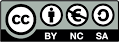

[Volver al inicio](#top)